In [1]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('../lib')
from local_paths import database_dir, mplstyle_path
from stats_utils import get_bootstrap_spread
from summary_utils import annotate_unit_df, select_units, region_palette

In [2]:
plt.style.use(mplstyle_path)

# Parameters

In [3]:
lat_df_path = (
    '../Postprocessing/Latency/summary/'
    'fix_on_latency-more.csv.gz')

# analysis-specific conditions
binwidth = 12.5

# unit selection
unit_sel_path = database_dir + 'unit_sel/fixation_selective.csv.gz'

# statistics
n_bootstraps = 1000
spread_type = 'ci_of_mean'
point_spread_type = 'ci_of_mean'

# Load data

In [4]:
df = pd.read_csv(lat_df_path)
df = df[df['Level']=='Unit'].rename(columns={'Name':'Unit'})
df = annotate_unit_df(df).reset_index()

# Select units

In [5]:
df, unit_sel, regions = select_units(
    df,
    selection_path=unit_sel_path)
lat_df = df.set_index(['Session', 'Unit'])

> Selected units: n = 4568 of 4736 (96.5% of data, 27.9% of selection) based on fixation_selective.csv.gz
> Excluded 4 rare subjects per region:
	                Units  Norm. units
	Region Subject                    
	AIT    Bf           2     0.033058
	       Na           2     0.033058
	CIT    Bf           3     0.017857
	       Re           3     0.017857
  Selected units: n = 4558 of 4568 (99.8%)


In [6]:
lat_df.reset_index()[['Session','Unit']].to_csv('unit_sel/fig5ab.csv.gz', index=False)

# Summarize results per region

In [7]:
unit_df = lat_df[['Region','Subject']].copy()
unit_df['Index'] = np.arange(len(unit_df))
rg = np.random.default_rng(0)
result_vals = lat_df['Latency'].values
result_dvals = lat_df['Boots. stdev.'].values

In [8]:
byregion_bysubj_vals = {}
byregion_bysubj_dvals = {}
byregion_bysubj_nunit = {}

for region, region_unit_df in unit_df.groupby('Region'):
    byregion_bysubj_vals[region] = bysubj_vals = {}
    byregion_bysubj_dvals[region] = bysubj_dvals = {}
    byregion_bysubj_nunit[region] = bysubj_nunit = {}

    for subj, subj_region_unit_df, in region_unit_df.groupby('Subject'):
        idc = subj_region_unit_df['Index'].values
        bysubj_vals[subj] = result_vals[..., idc]   # shape (ncond, nt, nu)
        bysubj_dvals[subj] = result_dvals[..., idc]   # shape (ncond, nt, nu)
        bysubj_nunit[subj] = idc.size

In [9]:
# define per-region bins for latency
byregion_bins = {}

u = np.ceil(result_vals.max() / binwidth) * binwidth

for region, df_ in unit_df.groupby('Region'):
    idc = df_['Index'].values
    vals_ = result_vals[idc]
    l = min(0, np.floor(vals_.min() / binwidth) * binwidth)
    byregion_bins[region] = np.arange(l, u+binwidth/2, binwidth)

In [10]:
def get_cdf(vals, bins):
    return np.cumsum(np.histogram(vals, bins=bins)[0]) / vals.size

In [11]:
byregion_byresult_center_boots = {}
byregion_bysubj_named_nunits = {}
byregion_bysubj_byresult_center_boots = {}
result_names = (
    'CDF', 'Latency', 'Stdev. latency',
    'Frac. < 0', 'Latency, < 0', 'Stdev. latency, < 0')
count_names = ('Neuron count', 'Lat. < 0 neuron count')

stat = np.nanmedian if 'of_median' in spread_type else np.nanmean
point_stat = np.nanmedian if 'of_median' in point_spread_type else np.nanmean


for region, bysubj_vals in byregion_bysubj_vals.items():
    subjs = np.array(list(bysubj_vals))
    bins = byregion_bins[region]
    bysubj_dvals = byregion_bysubj_dvals[region]


    # obtain per-region, per-subject estimates
    center = {k: np.full(subjs.size, np.nan) for k in result_names+count_names if k != 'CDF'}
    center['CDF'] = np.empty((subjs.size, bins.size-1))
    boots = {k: np.full((subjs.size, n_bootstraps), np.nan) for k in result_names if k != 'CDF'}
    boots['CDF'] = np.empty((subjs.size, n_bootstraps, bins.size-1))
    for i, (s, v) in enumerate(bysubj_vals.items()):
        dv = bysubj_dvals[s]
        assert v.shape[-1] == dv.shape[-1]
        center['Neuron count'][i] = v.shape[-1]
        center['CDF'][i] = get_cdf(v, bins)
        center['Latency'][i] = point_stat(v)
        center['Stdev. latency'][i] = point_stat(dv)
        m = v < 0
        center['Lat. < 0 neuron count'][i] = m.sum()
        center['Frac. < 0'][i] = m.mean()
        if m.any():
            center['Latency, < 0'][i] = point_stat(v[m])
            center['Stdev. latency, < 0'][i] = point_stat(dv[m])

        for ib in range(n_bootstraps):
            idc = rg.choice(v.size, v.size)
            v_ = v[idc]
            dv_ = dv[idc]
            boots['CDF'][i,ib] = get_cdf(v_, bins)
            boots['Latency'][i,ib] = point_stat(v_)
            boots['Stdev. latency'][i,ib] = point_stat(dv_)
            m = v_ < 0
            boots['Frac. < 0'][i,ib] = m.mean()
            if m.any():
                boots['Latency, < 0'][i,ib] = point_stat(v_[m])
                boots['Stdev. latency, < 0'][i,ib] = point_stat(dv_[m])

    byregion_bysubj_named_nunits[region] = {
        s: {k: int(center[k][i]) for k in count_names}
        for i, s in enumerate(subjs)}
    byregion_bysubj_byresult_center_boots[region] = {
        s: {k: (center[k][i], boots[k][i]) for k in result_names}
        for i, s in enumerate(subjs)}
    center = {k: dict(CDF=stat).get(k, point_stat)(v, 0) for k, v in center.items()}


    # obtain per-region estimates summarized across subjects
    boots = {k: np.empty(n_bootstraps) for k in result_names if k != 'CDF'}
    boots['CDF'] = np.empty((n_bootstraps, bins.size-1))
    for ib in range(n_bootstraps):
        boots_ = {k: np.full(subjs.size, np.nan) for k in result_names if k != 'CDF'}
        boots_['CDF'] = np.empty((subjs.size, bins.size-1))
        subjs_ = rg.choice(subjs, subjs.size)  # bootstrap-sample subjects
        for i, s in enumerate(subjs_):
            v = bysubj_vals[s]
            idc = rg.choice(v.size, v.size)  # bootstrap-sample units per subject
            v = v[idc]
            dv = bysubj_dvals[s][idc]
            boots_['CDF'][i] = get_cdf(v, bins)
            boots_['Latency'][i] = point_stat(v)
            boots_['Stdev. latency'][i] = point_stat(dv)
            m = v < 0
            boots_['Frac. < 0'][i] = m.mean()
            if m.any():
                boots_['Latency, < 0'][i] = point_stat(v[m])
                boots_['Stdev. latency, < 0'][i] = point_stat(dv[m])
        for k, v in boots_.items():
            stat_ = stat if k == 'CDF' else point_stat
            boots[k][ib] = stat_(v, 0)

    byregion_byresult_center_boots[region] = byresult_center_boots = {}
    for k in result_names:
        byresult_center_boots[k] = center[k], boots[k]

/tmp/ipykernel_242073/8960185.py:57: RuntimeWarning: Mean of empty slice
  center = {k: dict(CDF=stat).get(k, point_stat)(v, 0) for k, v in center.items()}
/tmp/ipykernel_242073/8960185.py:82: RuntimeWarning: Mean of empty slice
  boots[k][ib] = stat_(v, 0)


# Make plots

In [12]:
# Sanity check
for k0, d0 in byregion_bysubj_nunit.items():
    for k1, v1 in d0.items():
        assert v1 == byregion_bysubj_named_nunits[k0][k1]['Neuron count']

for n in count_names:
    print(n)
    for k0 in regions:
        d0 = byregion_bysubj_named_nunits[k0]
        print(k0+":\t", f'{sum(v[n] for v in d0.values())}/{len(d0)}')
    print()

Neuron count
V1:	 14/2
V2:	 28/1
V4:	 449/3
PIT:	 9/1
CIT:	 3512/5
AIT:	 546/4

Lat. < 0 neuron count
V1:	 3/2
V2:	 2/1
V4:	 2/3
PIT:	 0/1
CIT:	 35/5
AIT:	 71/4



center/spread estimate: ci_of_mean


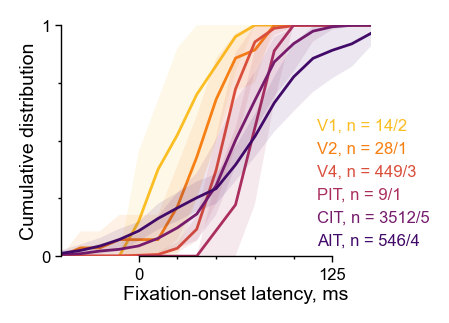

In [13]:
fig = plt.figure(figsize=(2,1.5))
ax = plt.gca()

for i, region in enumerate(regions):
    x = byregion_bins[region]
    c = region_palette[region]
    m, bs = byregion_byresult_center_boots[region]['CDF']

    plt.plot(x, np.insert(m,0,0), c=c, zorder=2+i/10)
    spread = np.insert(get_bootstrap_spread(m, bs, spread_type), 0, 0, axis=1)
    plt.fill_between(x, *spread, fc=c, ec='none', alpha=0.1, zorder=1.95+i/10)

xlim = (-50, 150)
xbound = (0, 125)
xtks = (0, 125)
xmtks = np.arange(xbound[0], xbound[1]+1, 25)
ax.set_xlim(xlim)
ax.set_xticks(xtks)
ax.set_xticks(xmtks, minor=True)
ax.spines['bottom'].set_bounds(xbound)
ax.set_xlabel('Fixation-onset latency, ms')

ylim = (0, 1)
ybound = (0, 1)
ytks = ybound
ymtks = np.arange(ybound[0], ybound[1]+.1, .25)
ax.set_ylim(ylim)
ax.set_yticks(ytks)
ax.set_yticks(ymtks, minor=True)
ax.spines['left'].set_bounds(ybound)
ax.set_ylabel('Cumulative distribution')

tform = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.xaxis.set_label_coords(np.mean(xbound), -.125, transform=tform)

h = .6
for region in regions:
    c = region_palette[region]
    ns = np.array(list(byregion_bysubj_nunit[region].values()))
    l = f'{region}, n = {ns.sum()}/{len(ns)}'
    ax.text(.825, h, l, ha='left', va='top',
            transform=ax.transAxes, color=c, fontsize=6)
    h -= .1

print('center/spread estimate:', spread_type)

plt.savefig('plots/fig5a.png')

In [14]:
t = 0
m = lat_df['Latency'] < t
print(f'{m.sum()} of {m.size} units ({m.mean()*100:.1f}%) have fix-on latency < {t} ms')
lat_df[m].index.to_frame(index=False).to_csv(f'unit_sel/lat_fix_lt_{t}.csv.gz', index=False)

113 of 4558 units (2.5%) have fix-on latency < 0 ms


# Get and plot point estimates

center/spread estimate: ci_of_mean


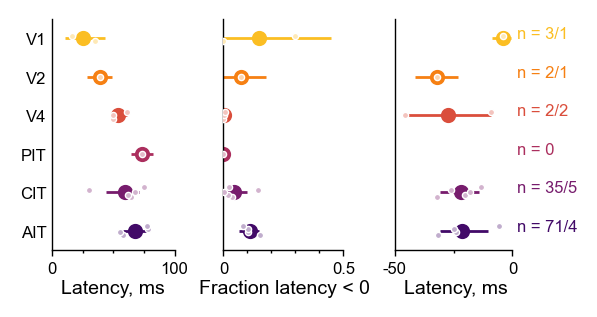

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(3, 1.5), sharey=True)
plt.subplots_adjust(wspace=0.4)

for res, ax in zip(('Latency', 'Frac. < 0', 'Latency, < 0'), axs):
    for i, region in enumerate(regions):
        y = len(regions) - 1 - i
        c = region_palette[region]
        m, bs = byregion_byresult_center_boots[region][res]
        ax.scatter(m, y, color=c, s=20)

        if np.isfinite(bs).any():
            spread = get_bootstrap_spread(m, bs, point_spread_type)
            ax.hlines(y, *spread, color=c)

        bysubj_center_boots = {
            s: v[res] for s, v in byregion_bysubj_byresult_center_boots[region].items()}
        subjs = np.array(list(bysubj_center_boots.keys()))
        js = (np.linspace(0, 1, subjs.size+2)[1:-1] - .5) * .4
        c = (2 + c) / 3
        for j, subj in zip(js, subjs):
            m, bs = bysubj_center_boots[subj]
            ax.scatter(m, y+j, fc=c, ec='w', s=5, lw=0.5, zorder=3)

for ax in axs:
    ax.set_ylim(-.5, len(regions)-.5)
    ax.tick_params(axis='y', length=0)

ax = axs[0]
xbound = (0, 100)
ax.set_xlim(xbound)
ax.set_xticks(xbound, tuple(map(str, xbound)))
ax.set_xticks(np.arange(*xbound, 25), minor=True)
ax.spines['bottom'].set_bounds(xbound)
ax.set_xlabel('Latency, ms')
ax.set_yticks(range(len(regions)), regions[::-1])

ax = axs[1]
xbound = (0, .5)
ax.set_xlim(0, .51)
ax.set_xticks(xbound, tuple(map(str, xbound)))
ax.set_xticks(np.arange(*xbound, .1), minor=True)
ax.spines['bottom'].set_bounds(xbound)
ax.set_xlabel('Fraction latency < 0')

ax = axs[2]
xbound = (-50, 0)
ax.set_xlim((-50, 2))
ax.set_xticks(xbound, tuple(map(str, xbound)))
ax.set_xticks(np.arange(*xbound, 25), minor=True)
ax.spines['bottom'].set_bounds(xbound)
ax.set_xlabel('Latency, ms')

t = mpl.transforms.blended_transform_factory(ax.transAxes, ax.transData)
n = 'Lat. < 0 neuron count'
for i, region in enumerate(regions):
    y = len(regions) - 1 - i
    c = region_palette[region]
    d = byregion_bysubj_named_nunits[region]
    d = {k: v[n] for k, v in d.items()}
    ns = list(v for v in d.values() if v)
    ns = f'{sum(ns)}/{len(ns)}' if ns else '0'
    ax.text(1, y, f'n = {ns}', color=c, fontsize=6, transform=t)

print('center/spread estimate:', point_spread_type)

plt.savefig('plots/fig5b.png')

In [16]:
print('center/spread estimate:', point_spread_type)
for res in ('Latency', 'Frac. < 0', 'Latency, < 0', 'Stdev. latency'):
    print(res)
    for i, region in enumerate(regions):
        m, bs = byregion_byresult_center_boots[region][res]
        if spread_type == 'ci_of_mean':
            if np.isfinite(bs).any():
                spread = get_bootstrap_spread(m, bs, spread_type)
            else:
                spread = [np.nan, np.nan]
            if 'Frac.' in res:
                print(f'{region}:\t{m*100:2.0f}%, {spread[0]*100:2.0f}% -- {spread[1]*100:2.0f}%')
            else:
                print(f'{region}:\t{m:3.0f}, {spread[0]:3.0f} -- {spread[1]:3.0f}')
        else:
            d = get_bootstrap_spread(m, bs, point_spread_type, return_dev=True)
            if 'Frac.' in res:
                print(f'{region}:\t{m*100:2.0f}% +/- {d*100:2.0f}%')
            else:
                print(f'{region}:\t{m:3.0f} +/- {d:3.0f}')
    print()

center/spread estimate: ci_of_mean
Latency
V1:	 25,  11 --  43
V2:	 39,  28 --  49
V4:	 54,  49 --  61
PIT:	 73,  64 --  83
CIT:	 60,  44 --  71
AIT:	 67,  56 --  79

Frac. < 0
V1:	15%,  0% -- 45%
V2:	 7%,  0% -- 18%
V4:	 0%,  0% --  1%
PIT:	 0%,  0% --  0%
CIT:	 4%,  1% -- 10%
AIT:	11%,  6% -- 15%

Latency, < 0
V1:	 -4,  -9 --  -1
V2:	-32, -41 -- -23
V4:	-27, -46 --  -9
PIT:	nan, nan -- nan
CIT:	-22, -31 -- -14
AIT:	-22, -31 -- -11

Stdev. latency
V1:	 11,   7 --  15
V2:	 21,  17 --  26
V4:	 20,  17 --  24
PIT:	 35,  30 --  41
CIT:	 23,  18 --  26
AIT:	 30,  26 --  35

